In [1]:
import pymc as pm
from pyhgf import load_data
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
from pyhgf.model import HGF
import matplotlib.pyplot as plt
import jax.numpy as jnp
from pyhgf.distribution import HGFDistribution
from pyhgf.response import first_level_binary_surprise, first_level_gaussian_surprise
import seaborn as sns
from math import log

u, y = load_data("binary")
continuous_timeseries = load_data("continuous")

## Binary

In [2]:
hgf_logp_op = HGFDistribution(
    n_levels=2,
    model_type="binary",
    input_data=[u],
    response_function=first_level_binary_surprise,
)

In [3]:
with pm.Model() as two_levels_binary_hgf:

    omega_2 = pm.Normal("omega_2", -1.5, 1.0)
    mu_2 = pm.Normal("mu_2", 0.0, 1.0)

    pm.Potential(
        "hgf_loglike",
        hgf_logp_op(
            omega_1=jnp.inf,
            omega_2=omega_2,
            binary_precision=jnp.inf,
            continuous_precision=jnp.inf,
            rho_1=0.0,
            rho_2=0.0,
            pi_1=0.0,
            pi_2=1e4,
            mu_1=jnp.inf,
            mu_2=mu_2,
            kappa_1=1.0,
            omega_3=jnp.nan,
            rho_3=jnp.nan,
            pi_3=jnp.nan,
            mu_3=jnp.nan,
            kappa_2=jnp.nan
        ),
    )

In [4]:
with two_levels_binary_hgf:
    two_level_hgf_idata = pm.sample(chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [omega_2, mu_2]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.


In [5]:
omega_2 = az.summary(two_level_hgf_idata)["mean"]["omega_2"]
mu_2 = az.summary(two_level_hgf_idata)["mean"]["mu_2"]

Creating a binary Hierarchical Gaussian Filter with 2 levels.
... Create the update sequence from the network structure.
... Create the belief propagation function.
... Cache the belief propagation function.
Adding 320 new observations.


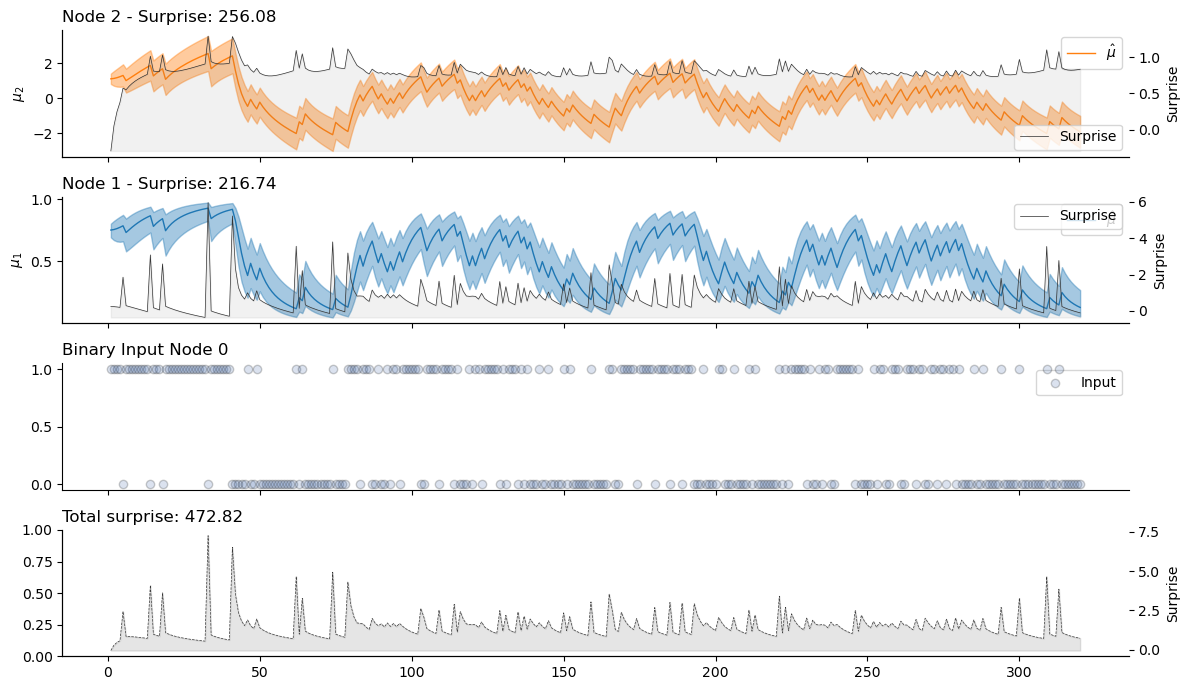

In [6]:
hgf_mcmc = HGF(
    n_levels=2,
    model_type="binary",
    initial_mu={"1": jnp.nan, "2": mu_2},
    initial_pi={"1": 0.0, "2": 1e4},
    omega={"1": jnp.nan, "2": omega_2}).input_data(
        input_data=u
    )
hgf_mcmc.plot_trajectories(figsize=(12, 7));
sns.despine()
plt.tight_layout()
plt.savefig("binary_trajectories.svg", dpi=600)

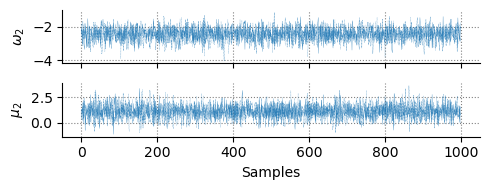

In [7]:
_, axs = plt.subplots(nrows=2, figsize=(5, 2), sharex=True)
for i, st in zip(range(4), ['-', '--', ':', '-.']):
    axs[0].plot(two_level_hgf_idata["posterior"]["omega_2"][i], linewidth=.2, color='#1f77b4', linestyle=st)
    axs[1].plot(two_level_hgf_idata["posterior"]["mu_2"][i], linewidth=.2, color='#1f77b4', linestyle=st)

axs[0].grid(color='grey', linestyle="dotted", zorder=3)
axs[1].grid(color='grey', linestyle="dotted", zorder=3)

axs[0].set_ylabel(r"$\omega_2$", size=10)
axs[1].set_ylabel(r"$\mu_2$", size=10)
axs[1].set_xlabel("Samples", size=10)
sns.despine()
plt.tight_layout()
plt.savefig("binary_traces.svg", dpi=600)

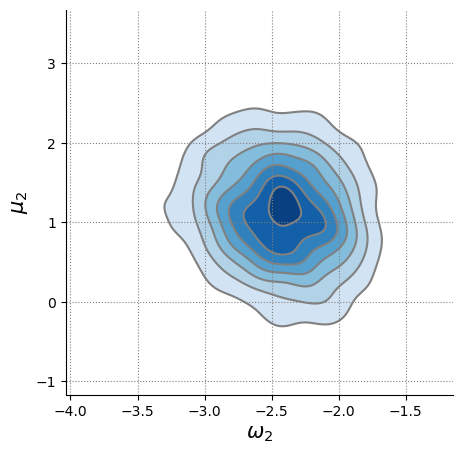

In [8]:
ax = az.plot_kde(
    two_level_hgf_idata["posterior"]["omega_2"],
    two_level_hgf_idata["posterior"]["mu_2"],
    contourf_kwargs={"cmap": "Blues"},
    figsize=(5, 5)
)
plt.grid(color='grey', linestyle="dotted", zorder=3)
ax.set_xlabel(r"$\omega_2$", size=15)
ax.set_ylabel(r"$\mu_2$", size=15)
sns.despine()
plt.savefig("binary_posterior.svg", dpi=600)

## Continuous

In [9]:
hgf_logp_op = HGFDistribution(
    n_levels=2,
    model_type="continuous",
    input_data=[continuous_timeseries],
    response_function=first_level_gaussian_surprise,
)

In [10]:
with pm.Model() as three_level_hgf:

    omega_1 = pm.Normal("omega_1", -4, 2.0)
    mu_1 = pm.Normal("mu_1", -4, 2.0)

    pm.Potential(
        "hgf_loglike",
        hgf_logp_op(
            omega_1=omega_1,
            omega_2=-2.0,
            omega_3=np.nan,
            continuous_precision=1e4,
            binary_precision=np.nan,
            rho_1=0.0,
            rho_2=0.0,
            rho_3=np.nan,
            pi_1=1e4,
            pi_2=1e1,
            pi_3=np.nan,
            mu_1=mu_1,
            mu_2=-2.0,
            mu_3=np.nan,
            kappa_1=1.0,
            kappa_2=np.nan,
        ),
    )

In [11]:
with three_level_hgf:
    three_level_hgf_idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [omega_1, mu_1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.


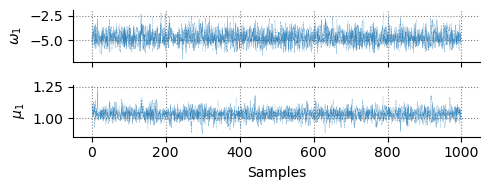

In [12]:
_, axs = plt.subplots(nrows=2, figsize=(5, 2), sharex=True)
for i, st in zip(range(4), ['-', '--', ':', '-.']):
    axs[0].plot(three_level_hgf_idata["posterior"]["omega_1"][i], linewidth=.2, color='#1f77b4', linestyle=st)
    axs[1].plot(three_level_hgf_idata["posterior"]["mu_1"][i], linewidth=.2, color='#1f77b4', linestyle=st)

axs[0].grid(color='grey', linestyle="dotted", zorder=3)
axs[1].grid(color='grey', linestyle="dotted", zorder=3)

axs[0].set_ylabel(r"$\omega_1$", size=10)
axs[1].set_ylabel(r"$\mu_1$", size=10)
axs[1].set_xlabel("Samples", size=10)
sns.despine()
plt.tight_layout()
plt.savefig("continuous_traces.svg", dpi=600)

In [13]:
omega_1 = az.summary(three_level_hgf_idata)["mean"]["omega_1"]
mu_1 = az.summary(three_level_hgf_idata)["mean"]["mu_1"]

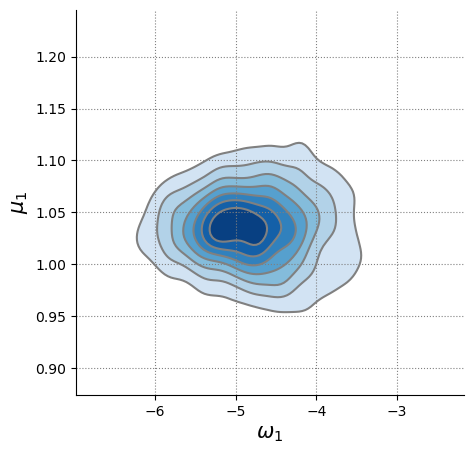

In [14]:
ax = az.plot_kde(
    three_level_hgf_idata["posterior"]["omega_1"],
    three_level_hgf_idata["posterior"]["mu_1"],
    contourf_kwargs={"cmap": "Blues"},
    figsize=(5, 5)
)
plt.grid(color='grey', linestyle="dotted", zorder=3)
ax.set_xlabel(r"$\omega_1$", size=15)
ax.set_ylabel(r"$\mu_1$", size=15)
sns.despine()
plt.savefig("continuous_posterior.svg", dpi=600)

Creating a continuous Hierarchical Gaussian Filter with 2 levels.
... Create the update sequence from the network structure.
... Create the belief propagation function.
... Cache the belief propagation function.
Adding 614 new observations.


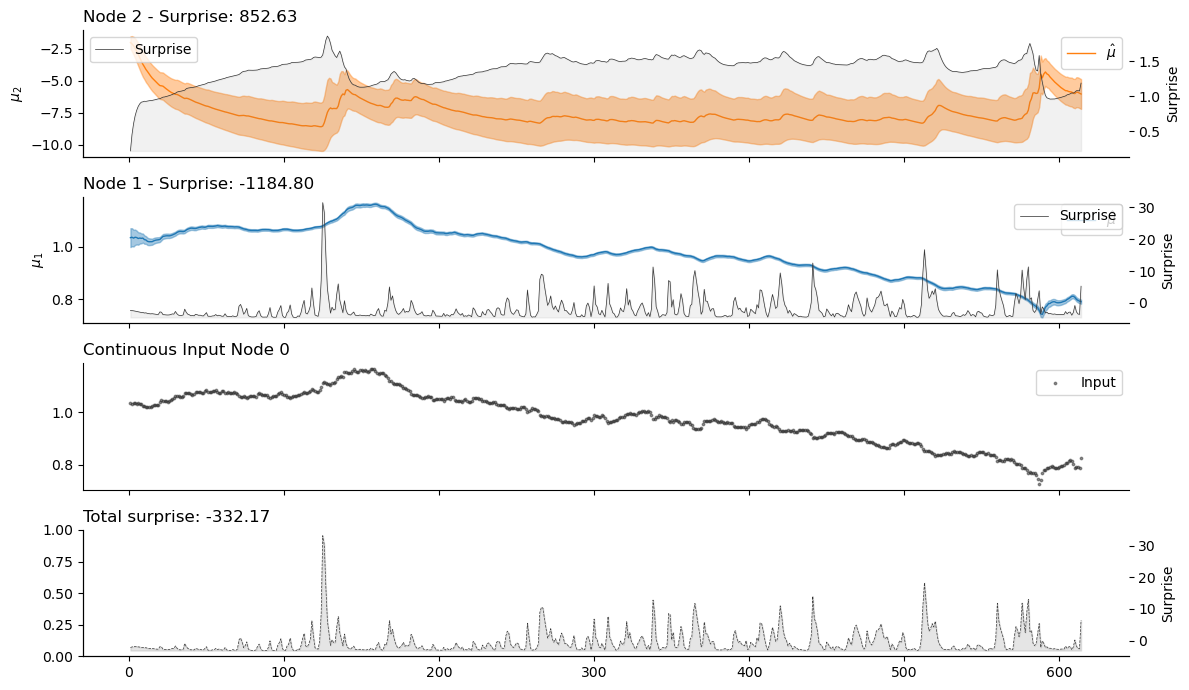

In [15]:
hgf_mcmc = HGF(
    n_levels=2,
    model_type="continuous",
    initial_mu={"1": mu_1, "2": -2.0},
    initial_pi={"1": 1e4, "2": 1e1, "3": 1e1},
    omega={"1": omega_1, "2": -2.0}).input_data(
        input_data=continuous_timeseries
    )
hgf_mcmc.plot_trajectories(figsize=(12, 7));
sns.despine()
plt.tight_layout()
plt.savefig("continuous_trajectories.svg", dpi=600)